<a href="https://colab.research.google.com/github/mvharsh/Deep-Learning/blob/main/RNN/RNN_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import Necessary Libraries:**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error


#**Load and Preprocess Data:**

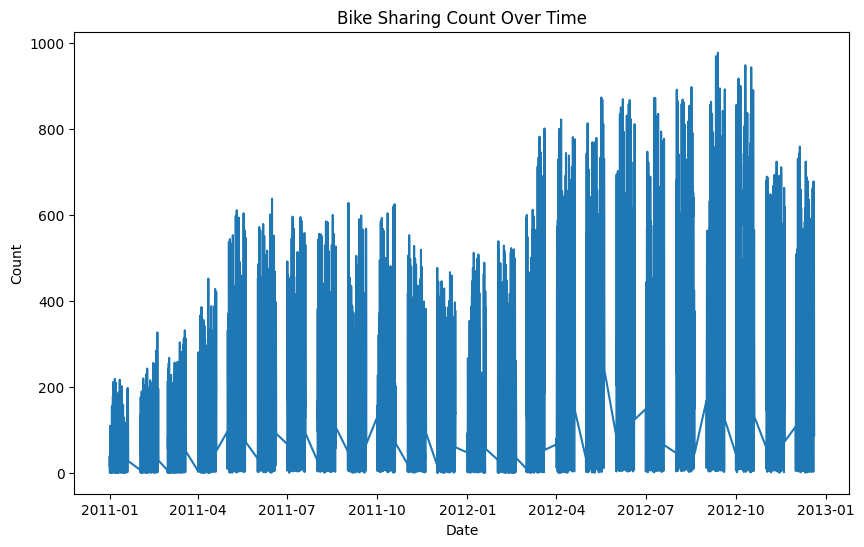

In [ ]:
# Load data
data = pd.read_csv("/content/drive/MyDrive/Time Series Dataset.csv")

# Convert 'datetime' column to datetime datatype
data['datetime'] = pd.to_datetime(data['datetime'])

# Plot the data
plt.figure(figsize=(10,6))
plt.plot(data['datetime'], data['count'])
plt.title('Bike Sharing Count Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()

# Prepare data
scaler = MinMaxScaler()
data['count'] = scaler.fit_transform(data['count'].values.reshape(-1,1))


#**EDA (Exploratory Data Analysis):**

In [ ]:
# Statistical Summary
print("Statistical Summary of the Data:")
print(data.describe())


Statistical Summary of the Data:
                            datetime        season       holiday  \
count                          10886  10886.000000  10886.000000   
mean   2011-12-27 05:56:22.399411968      2.506614      0.028569   
min              2011-01-01 00:00:00      1.000000      0.000000   
25%              2011-07-02 07:15:00      2.000000      0.000000   
50%              2012-01-01 20:30:00      3.000000      0.000000   
75%              2012-07-01 12:45:00      4.000000      0.000000   
max              2012-12-19 23:00:00      4.000000      1.000000   
std                              NaN      1.116174      0.166599   

         workingday       weather         temp         atemp      humidity  \
count  10886.000000  10886.000000  10886.00000  10886.000000  10886.000000   
mean       0.680875      1.418427     20.23086     23.655084     61.886460   
min        0.000000      1.000000      0.82000      0.760000      0.000000   
25%        0.000000      1.000000     13.9

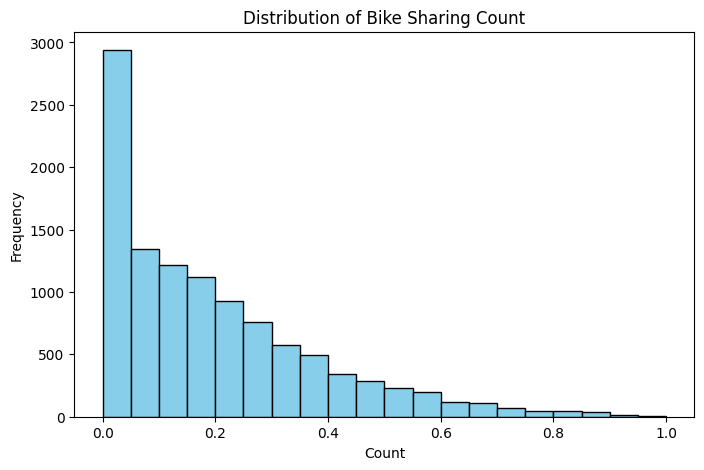

In [ ]:
# Distribution of Count
plt.figure(figsize=(8, 5))
plt.hist(data['count'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Bike Sharing Count')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()


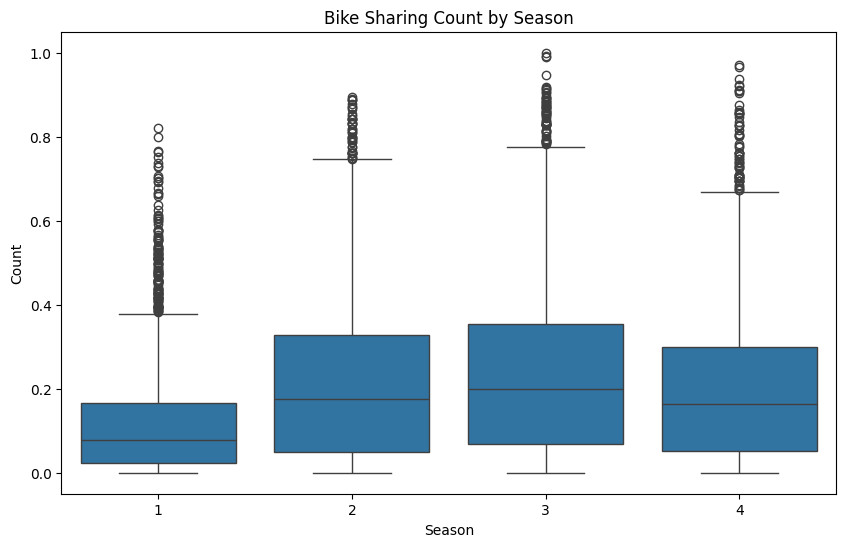

In [ ]:
# Boxplot of Count by Season
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='count', data=data)
plt.title('Bike Sharing Count by Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.show()

#**Create Training and Testing Data:**

In [ ]:
# Split data into train and test
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = data.iloc[0:train_size], data.iloc[train_size:len(data)]

# Function to create dataset
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 12

X_train, y_train = create_dataset(train[['count']], train['count'], time_steps)
X_test, y_test = create_dataset(test[['count']], test['count'], time_steps)


#**Build and Train RNN Model:**

In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=1, shuffle=False)


Epoch 1/100
490/490 [==============================] - 7s 8ms/step - loss: 0.0075 - val_loss: 0.0118
Epoch 2/100
490/490 [==============================] - 3s 7ms/step - loss: 0.0055 - val_loss: 0.0100
Epoch 3/100
490/490 [==============================] - 4s 7ms/step - loss: 0.0047 - val_loss: 0.0071
Epoch 4/100
490/490 [==============================] - 5s 9ms/step - loss: 0.0036 - val_loss: 0.0061
Epoch 5/100
490/490 [==============================] - 3s 7ms/step - loss: 0.0032 - val_loss: 0.0051
Epoch 6/100
490/490 [==============================] - 3s 7ms/step - loss: 0.0029 - val_loss: 0.0045
Epoch 7/100
490/490 [==============================] - 4s 8ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 8/100
490/490 [==============================] - 4s 8ms/step - loss: 0.0025 - val_loss: 0.0039
Epoch 9/100
490/490 [==============================] - 3s 7ms/step - loss: 0.0024 - val_loss: 0.0035
Epoch 10/100
490/490 [==============================] - 3s 7ms/step - loss: 0.0022 - val_lo

#**Evaluate the Model:**

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
test_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')


68/68 [==============================] - 0s 3ms/step
Train RMSE: 43.28350906319948
Test RMSE: 56.55499790675484


#**Visualize Predictions:**

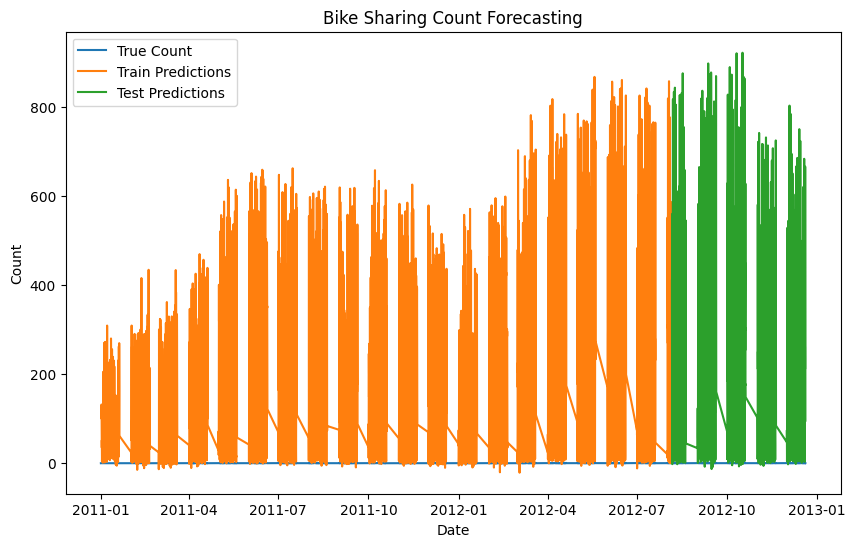

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(data['datetime'], data['count'], label='True Count')
plt.plot(train['datetime'].iloc[time_steps:], train_predict, label='Train Predictions')
plt.plot(test['datetime'].iloc[time_steps:], test_predict, label='Test Predictions')

plt.title('Bike Sharing Count Forecasting')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()
